In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys  
sys.path.append("../l2hmc")
sys.path.append("../l2hmc/utils")

import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from utils.distributions import random_tilted_gaussian, Gaussian, GMM, RoughWell

import seaborn as sns
sns.set_palette("muted")

In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples, plot_gaussian_contours

In [3]:
# Color definition for plots
c_l2hmc, c_hmc1, c_hmc2, c_hmc3 = 'blue', 'orange', 'green', 'red'
c_true, c_contour = 'purple', '0.75'

---
# Network architecture

In [4]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 10, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 10, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 10, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(10, 10, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(10, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(10, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(10, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net


---
# 2D Strongly Correlated Gaussian (SCG)

## Defining the distribution

We define our energy function. It is a Gaussian distribution with zero mean. The covariance is a $\pi/4$ rotation of the eigenvalues $[100, 10^{-1}]$. We set up our dynamics which take as input our energy function, the number of time step of our operator, the (learnable) step-size and our architecture.

In [5]:
x_dim = 2
mu = np.zeros(2,)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])
dist = Gaussian(mu, cov)
# mu, cov = random_tilted_gaussian(x_dim)
print(mu, cov)
dist = Gaussian(mu, cov)

9.999999999999705 float64
(array([0., 0.]), array([[ 50.05, -49.95],
       [-49.95,  50.05]]))
9.999999999999705 float64


We can directly sample from this distribution and plot it for sanity-check. Here, we sample 400 points from $\Omega$.

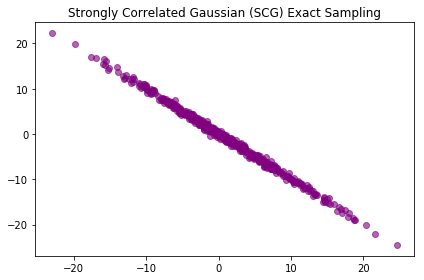

In [55]:
S = dist.get_samples(500)
fig = plt.figure()
plt.title('Strongly Correlated Gaussian (SCG) Exact Sampling')
plt.plot(S[:, 0], S[:, 1], 'o', alpha=0.6, color=c_true)
plt.tight_layout()
# plt.axis('equal')
plt.show()
fig.savefig('scg_exact.png', dpi=200)

In [45]:
# x_lim, y_lim = np.max(S[:, 0]), np.max(S[:, 1])
# x_lims, y_lims = [-x_lim, x_lim], [-y_lim, y_lim]
# plot_gaussian_contours([mu], [cov], x_lims=x_lims, y_lims=y_lims, spacing=3)
# plt.axis('equal')
# plt.show()

---
## Training


We set up the loss on both $p(\xi)$ (here `x`) and $q(\xi)$ (here `z`). We then train with Adam with a learning rate of $10^{-3}$.

In [8]:
# Leap frog integrator for Hamiltonian dynamics
dynamics = Dynamics(x_dim, dist.get_energy_function(), T=10, eps=0.1, net_factory=network)

# Losses on p(xi) and q(xi), respectively
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))
Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

# Squared jumped distance
v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.1

# Update loss
loss = 0.
loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale

In [9]:
# Training parameters
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

Training loop described in Algorithm 1 in the paper.

In [10]:
n_steps = 5000
n_samples = 200

samples = np.random.randn(n_samples, x_dim)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for t in range(n_steps):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples})

    if t % 100 == 0:
        print('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss_, np.mean(px_), lr_))

Step: 0 / 5000, Loss: -3.79e+01, Acceptance sample: 0.82, LR: 0.00100
Step: 100 / 5000, Loss: -1.93e+02, Acceptance sample: 0.72, LR: 0.00100
Step: 200 / 5000, Loss: -3.66e+02, Acceptance sample: 0.57, LR: 0.00100
Step: 300 / 5000, Loss: -5.74e+02, Acceptance sample: 0.51, LR: 0.00100
Step: 400 / 5000, Loss: -4.99e+03, Acceptance sample: 0.28, LR: 0.00100
Step: 500 / 5000, Loss: -6.56e+03, Acceptance sample: 0.36, LR: 0.00100
Step: 600 / 5000, Loss: -6.87e+03, Acceptance sample: 0.33, LR: 0.00100
Step: 700 / 5000, Loss: -7.52e+03, Acceptance sample: 0.40, LR: 0.00100
Step: 800 / 5000, Loss: -7.95e+03, Acceptance sample: 0.43, LR: 0.00100
Step: 900 / 5000, Loss: -6.97e+03, Acceptance sample: 0.40, LR: 0.00100
Step: 1000 / 5000, Loss: -8.68e+03, Acceptance sample: 0.47, LR: 0.00096
Step: 1100 / 5000, Loss: -8.29e+03, Acceptance sample: 0.40, LR: 0.00096
Step: 1200 / 5000, Loss: -9.07e+03, Acceptance sample: 0.41, LR: 0.00096
Step: 1300 / 5000, Loss: -7.55e+03, Acceptance sample: 0.41, LR

---
## Evaluating
After training, we generate 200 chains for 2000 steps for evaluation purposes.

In [11]:
samples = dist.get_samples(n=n_samples)
final_samples = []

for t in range(2000):
    final_samples.append(np.copy(samples))

    feed_dict = {
        x: samples,
    }

    samples = sess.run(output[0], feed_dict)

We compute the HMC chains with **auto-correlation spectrums** as well.

In [13]:
L2HMC_samples = np.array(final_samples)
HMC_samples_1 = get_hmc_samples(2, 0.1, dist.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_2 = get_hmc_samples(2, 0.15, dist.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_3 = get_hmc_samples(2, 0.2, dist.get_energy_function(), sess, steps=2000, samples=samples)

In [14]:
scale = np.sqrt(np.trace(cov))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

---
## Auto-correlation plot

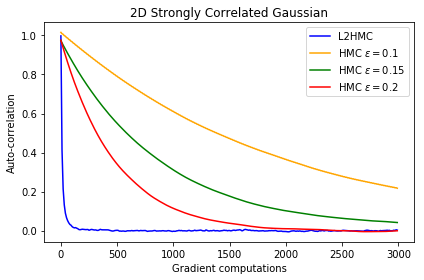

In [51]:
xaxis = 10 * np.arange(300)
fig = plt.figure()
plt.plot(xaxis, L2HMC[:300], label='L2HMC', color=c_l2hmc)
plt.plot(xaxis, HMC1[:300], label='HMC $\epsilon=0.1$', color=c_hmc1)
plt.plot(xaxis, HMC2[:300], label='HMC $\epsilon=0.15$', color=c_hmc2)
plt.plot(xaxis, HMC3[:300], label='HMC $\epsilon=0.2$', color=c_hmc3)
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient computations')
plt.legend()
plt.title('2D Strongly Correlated Gaussian')
plt.tight_layout()
plt.show()
fig.savefig('scg_plot.png', dpi=200)

We now compute the **Effective Sample Size** (ESS).

In [16]:
print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

ESS L2HMC: 3.29e-01 -- ESS HMC: 6.09e-03 -- Ratio: 53


Finally, we visualize a single chain of L2HMC for 50 time steps to assess exploration.

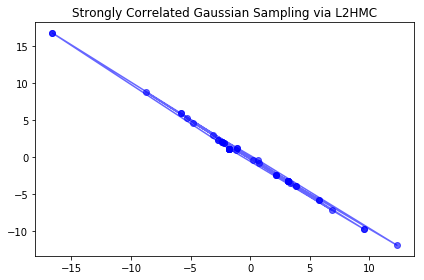

In [53]:
# plt.plot(S[:, 0], S[:, 1], 'o', alpha=0.6, color=c_true)
fig = plt.figure()
plt.plot(L2HMC_samples[:50, 1, 0], L2HMC_samples[:50, 1, 1], color=c_l2hmc, marker='o', alpha=0.6)
plt.title('Strongly Correlated Gaussian Sampling via L2HMC')
plt.tight_layout()
plt.show()
fig.savefig('scg_explore.png', dpi=200)